**Наличие объекта на изображении**
Необходимо обучить классификационную модель, которая определяет наличие объекта на изображении. Модель должна возвращать:

`0, если объекта на изображении нет.`

`1, если объект на изображении присутствует.`

Особенность задачи заключается в том, что датасет является сегментационным, поэтому информацию о масках необходимо учитывать при обучении модели. Один из подходов — использовать результаты энкодинга модели UNet в качестве входных данных для классификатора. Классификационная и сегментационная модели должны обучаться одновременно. Допустимо использование другого подхода при условии его обоснования и описания его преимуществ. Обучать только сегментационную модель и определять класс по порогу нельзя — решение о наличии объекта должна принимать нейронная сеть.


Оценку проводить на тестовой выборке (20% от датасета). Формировать валидационную выборку не обязательно.
Анализировать **accuracy, precision, recall.**
Реализовать функцию для запуска модели на изображении.
Запустить модель на изображении, где объект есть и где объекта нет.

---
**Описание датасета**

Датасет состоит из двух папок: images : содержит изображения.
masks : содержит маски.
Соответствующие друг другу изображения и маски имеют одинаковые названия
(различаются только расширения).
При решении можно использовать любые библиотеки, например, можно воспользоваться библиотекой с готовой реализацией Unet.
Задачу нужно выполнять в Jupyter Notebook, локально или в любом облаке (например, Google Colab).
  

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
import os
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import albumentations as A
import tqdm

from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.9). Upgrade using: pip install --upgrade albumentations


### Parameters

In [2]:
IMAGES_PATH = 'dataset/images'
MASKS_PATH = 'dataset/masks'

IM_HEIGHT = 256
IM_WIDTH = 256

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

unet_params = {
    'nc': 32, 
    'num_downs': 5, 
    'in_nc': 3,
    'out_nc': 1
}

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{DEVICE = }')

DEVICE = 'cuda'


## Data 
---

### Datasets and dataloaders

In [3]:
transform = A.Compose([
    #A.Resize(height=IM_HEIGHT, width=IM_WIDTH),
    A.SmallestMaxSize(max_size = min(IM_HEIGHT, IM_WIDTH)),
    A.RandomCrop(height=IM_HEIGHT, width=IM_WIDTH, always_apply=True),    
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=25, p=0.5)
])

class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms=None):
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imagePaths)
        
    def __getitem__(self, idx):
        imagePath = self.imagePaths[idx]
        image = cv2.imread(imagePath, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.
        
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.
        
        if self.transforms is not None: 
            transformed = self.transforms(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            
        label = 1 if np.max(mask)>0 else 0

        return (image, mask, label)


In [4]:
imagePaths = sorted(os.listdir(IMAGES_PATH))
imagePaths = [os.path.join(IMAGES_PATH, x).replace('\\','/') for x in imagePaths]
maskPaths = sorted(os.listdir(MASKS_PATH))
maskPaths = [os.path.join(MASKS_PATH, x).replace('\\','/') for x in maskPaths]
 
X_train, X_test, y_train, y_test = train_test_split(imagePaths, maskPaths, test_size=0.2, random_state=42)

# train
train_dataset = SegmentationDataset(X_train, y_train, transforms=transform) 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# test
test_dataset = SegmentationDataset(X_test, y_test, transforms=transform) 
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print('train_dataset images:', len(train_dataset))
print('test_dataset images:', len(test_dataset))
images, masks, labels = next(iter(train_loader))
print(f'train_loader  {images.shape = }, {masks.shape = }')

train_dataset images: 160
test_dataset images: 40
train_loader  images.shape = torch.Size([32, 256, 256, 3]), masks.shape = torch.Size([32, 256, 256])


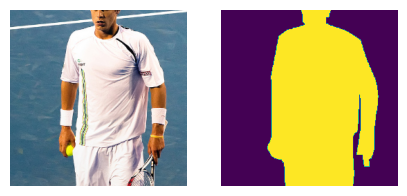

Image label : 1


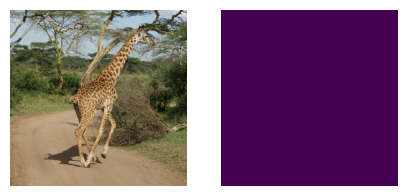

Image label : 0


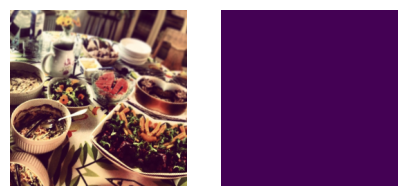

Image label : 0


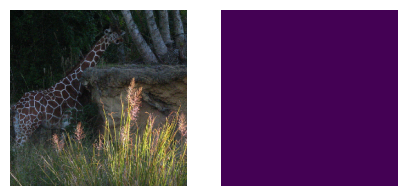

Image label : 0


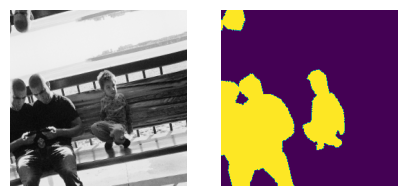

Image label : 1


In [5]:
for i in range(5):
    idx = i #random.randint(0, len(train_dataset)-1)
    image, mask, label = train_dataset[idx]
    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 7))
    ax[0].imshow(image )
    ax[1].imshow(mask)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    plt.show()
    print('Image label :' , label)

### Class weights

In [6]:
total_labels = 0
positive_labels = 0
for _, data in enumerate(train_dataset):
    total_labels += 1
    positive_labels += data[2]

print(f'Images with persons in train dataset {positive_labels/total_labels:.2%}')

Images with persons in train dataset 47.50%


## Models
---

### Unet segmentation model

In [7]:

class CNA(nn.Module):
    '''
    Convolution-Normalize-Activation block
    '''
    def __init__(self, in_nc, out_nc, stride=1):
        '''
        Convolution-Normalize-Activation block init

        Parameters:
        ------

        in_nc: input channels 
        out_nc: output channels 
        stride: convolution stride

        '''
        super().__init__()
        self.conv = nn.Conv2d(in_nc, out_nc, 3, stride=stride, padding=1, bias=False)
        self.norm = nn.BatchNorm2d(out_nc)
        self.act = nn.GELU()
    
    def forward(self, x):
        out = self.conv(x)
        out = self.norm(out)
        out = self.act(out)
        
        return out

class UnetBlock(nn.Module):
    '''
    Unet block with skip connection
    '''
    def __init__(self, in_nc, inner_nc, out_nc, inner_block=None):
        super().__init__()
        
        self.conv1 = CNA(in_nc, inner_nc, stride=2)
        self.conv2 = CNA(inner_nc, inner_nc)
        self.inner_block = inner_block
        self.conv3 = CNA(inner_nc, inner_nc)
        self.conv_cat = nn.Conv2d(inner_nc+in_nc, out_nc, 3, padding=1)
        
    def forward(self, x):
        _,_,h,w = x.shape
        
        inner = self.conv1(x)
        inner = self.conv2(inner)

        if self.inner_block is not None:
            inner = self.inner_block(inner)
        inner = self.conv3(inner)
        
        inner = F.upsample(inner, size=(h,w), mode='bilinear')

        # skip connection
        inner = torch.cat((x, inner), axis=1)
        out = self.conv_cat(inner)
        
        return out


class Unet(nn.Module):
    def __init__(self, in_nc=3, nc=32, out_nc=1, num_downs=5):
        """
            Init Unet model.
            
            Parameters:
            ------
            in_nc: input channels
            nc: inner channels
            out_nc: output channels
            num_downs: downstream steps
        """
        super().__init__()
        self.out_nc = out_nc
        # input convolution blocks
        self.cna1 = CNA(in_nc, nc)
        self.cna2 = CNA(nc, nc)
        
        # generate unet blocks with skip connections
        unet_block = None
  
        for i in range(num_downs-1, 0, -1):
            mul = 2 ** i
            inner_mul = 2 ** i if  i == num_downs else 2 ** i * 2
            unet_block = UnetBlock(mul*nc, inner_mul*nc, mul*nc, unet_block)

        self.unet_block = UnetBlock(nc, 2*nc, nc, unet_block)
        self.cna3 = CNA(nc, nc)
        self.conv_last = nn.Conv2d(nc, out_nc, 3, padding=1)    
    

    def forward(self, x):
        out = self.cna1(x)
        out = self.cna2(out)
        out = self.unet_block(out)
        out = self.cna3(out)
        out = self.conv_last(out)
        
        if self.out_nc==1:
            out = F.sigmoid(out)
        return out


def test():
    x = torch.randn((3, 1, IM_HEIGHT, IM_WIDTH))
    model = Unet(in_nc=1)
    preds = model(x)
    print(preds.shape)
    assert preds.shape == x.shape
test()

torch.Size([3, 1, 256, 256])


In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
model_unet = Unet(**unet_params).to(DEVICE)
print('Trainable parameters:', count_parameters(model_unet))

Trainable parameters: 40887201


### Classification model

In [10]:
class ImageBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(int(IM_HEIGHT/4*IM_WIDTH/4), 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(x)
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x
        
def test():
    x = torch.randn((3, 1, IM_HEIGHT, IM_WIDTH))
    model = ImageBinaryClassifier()
    preds = model(x)
    print(preds.shape)

test()

torch.Size([3, 1])


In [11]:
model_binary = ImageBinaryClassifier().to(DEVICE)
print('Trainable parameters:', count_parameters(model_binary))

Trainable parameters: 501889


### Combined model

In [12]:
class CombinedModel(nn.Module):
    def __init__(self, unet, classifier, device):
        super(CombinedModel, self).__init__()
        self.unet = unet
        self.classifier = classifier
        self.device = device
        
        self.loss_fn1 = nn.BCELoss().to(self.device)
        self.loss_fn2 = nn.BCELoss().to(self.device)
        
        self.optimizer1 = torch.optim.Adam(self.unet.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
        self.optimizer2 = torch.optim.Adam(self.classifier.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    
        self.scheduler1 = torch.optim.lr_scheduler.ExponentialLR(self.optimizer1, gamma=0.99)
        self.scheduler2 = torch.optim.lr_scheduler.ExponentialLR(self.optimizer2, gamma=0.99)

    def forward(self, x):
        x = self.unet(x)
        x = self.classifier(x)
        return x

    def preprocess(self, x):
        # extend single image input to batch size 1
        if len(x.shape)<4:
            x = x[None, :, :, :]
        x = torch.tensor(x)
        x = x.type(torch.float)
        x = x.permute((0,3,1,2))
        x = x.to(self.device)
        return x
    
    def train(self, sample):
        '''
        Train on single batch
        '''
        images, masks, labels = sample
        images = self.preprocess(images).to(self.device)
        masks = masks[:, None, :, :]
        masks = masks.to(self.device).float()
        labels = labels.to(self.device).float()
        labels = labels[:, None]

        # segmentation model
        self.optimizer1.zero_grad()
        pred1 = self.unet(images)
        loss1 = self.loss_fn1(pred1, masks)
        loss1.backward()
        loss1_item = loss1.item()
        self.optimizer1.step()

        # classification model
        self.optimizer2.zero_grad()
        pred2 = self.classifier(pred1.detach())
        loss2 = self.loss_fn2(pred2, labels)
        loss2.backward()
        loss2_item = loss2.item()
        self.optimizer2.step() 

        return loss1_item, loss2_item 

    def eval(self, sample):
        '''
        Evalueate on single batch

        Returns:
        ----
        loss unet
        loss classifier
        predictions
        true labels
        '''        
        images, masks, labels = sample
        images = self.preprocess(images).to(self.device)
        masks = masks[:, None, :, :]
        masks = masks.to(self.device).float()
        labels = labels.to(self.device).float()
        labels = labels[:, None]
      
        with torch.no_grad():

            # segmentation model
            pred1 = self.unet(images)
            loss1 = self.loss_fn1(pred1, masks)
            loss1_item = loss1.item()
 
            # classification model
            pred2 = self.classifier(pred1)
            loss2 = self.loss_fn2(pred2, labels)
            loss2_item = loss2.item()

        return loss1_item, loss2_item, pred2, labels
        
        
    def scheduler_step(self):
        self.scheduler1.step()
        self.scheduler2.step()
        
def test():
    x = torch.randn((3, 3, IM_HEIGHT, IM_WIDTH)).to(DEVICE)
    model = CombinedModel(model_unet, model_binary, DEVICE).to(DEVICE)
    preds = model(x)
    print('Output shape:', preds.shape)
    
test()

Output shape: torch.Size([3, 1])


In [13]:
model_combined = CombinedModel(model_unet, model_binary, DEVICE).to(DEVICE)
print('Trainable parameters:', count_parameters(model_combined))

Trainable parameters: 41389090


## Training
---

### Train combined model

In [14]:
def preprocess(x):
    # extend single image input to batch size 1
    if len(x.shape)<4:
        x = x[None, :, :, :]
    x = torch.tensor(x)
    x = x.type(torch.float)
    x = x.permute((0,3,1,2))
    return x

def show_intermediate_results(images, pred, masks):
    figure, ax = plt.subplots(nrows=1, ncols=4, figsize=(5, 7))
    ax[0].imshow(torch.permute(images[0], (1, 2, 0)).detach().cpu().numpy())
    m = masks[0][0].detach().cpu().numpy()
    ax[1].imshow(m)

    p = pred[0][0].detach().cpu().numpy()
    ax[2].imshow(p)
    ax[3].imshow((p > 0.5))

    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    ax[3].set_axis_off()
    plt.show()
    
def train(model, num_epochs, 
          train_loader, test_loader, device ):
            
        for epoch in tqdm.tqdm(range(num_epochs)):
            loss_val = [0, 0]
            loss_test = [0, 0] 
            y_pred = np.array([])
            y_true = np.array([])
            
            # -----------------------------------------
            # training
            # -----------------------------------------
            for sample in train_loader: #(pbar := tqdm.tqdm(train_loader)):

                loss1_item, loss2_item= model.train(sample)
                loss_val[0] += loss1_item
                loss_val[1] += loss2_item         
            
            model.scheduler_step()
            
            # -----------------------------------------
            # evaluation
            # -----------------------------------------            
            with torch.no_grad():
                for sample in test_loader: #(pbar := tqdm.tqdm(test_loader)):

                    loss1_item, loss2_item, batch_y_pred, batch_y_true = model.eval(sample)
                    loss_test[0] += loss1_item
                    loss_test[1] += loss2_item   

                    batch_y_pred = batch_y_pred.cpu().squeeze().numpy()                    
                    batch_y_pred = (batch_y_pred < 0.5).astype(np.int8)

                    batch_y_true = batch_y_true.cpu().squeeze().numpy()
                    batch_y_true = (batch_y_true < 0.5).astype(np.int8)
                    
                    y_pred = np.concatenate([y_pred, batch_y_pred]) # batch_y_pred.squeeze().tolist()
                    y_true = np.concatenate([y_true, batch_y_true]) # batch_y_true.squeeze().tolist()
                
            # -----------------------------------------
            # show intermediate results
            # -----------------------------------------            
            if epoch % 25 == 0 or epoch==num_epochs-1:
                epoch_train_loss = loss_val[0]/len(train_loader)
                epoch_val_loss = loss_test[0]/len(test_loader)
                echo = f'Segmenter \tepoch: {epoch+1}\t'
                echo += f'train loss: {epoch_train_loss:.14f}\t'
                echo += f'val loss: {epoch_val_loss:.14f}\t'
                echo += f'lr: {model.scheduler1.get_last_lr()[0]:.8f}'
                print(echo)
                
                epoch_train_loss = loss_val[1]/len(train_loader)
                epoch_val_loss = loss_test[1]/len(test_loader)
                echo = f'Classifier \tepoch: {epoch+1}\t'
                echo += f'train loss: {epoch_train_loss:.14f}\t'
                echo += f'val loss: {epoch_val_loss:.14f}\t'
                echo += f'lr: {model.scheduler2.get_last_lr()[0]:.8f}'
                print(echo)

                print(f'accuracy: {accuracy_score(y_true, y_pred)}')
                print(f'precision: {precision_score(y_true, y_pred)}')
                print(f'recall: {recall_score(y_true, y_pred)}')


                #show_intermediate_results(images, pred, masks)

        return 0

In [15]:
train(model_combined, EPOCHS, train_loader, test_loader, DEVICE)

  1%|▋                                                                      | 1/100 [00:01<03:10,  1.92s/it]

Segmenter 	epoch: 1	train loss: 0.66102679967880	val loss: 0.64309647679329	lr: 0.00009900
Classifier 	epoch: 1	train loss: 0.69829635620117	val loss: 0.69762030243874	lr: 0.00009900
accuracy: 0.45
precision: 0.45
recall: 1.0


 26%|██████████████████▏                                                   | 26/100 [00:44<02:07,  1.72s/it]

Segmenter 	epoch: 26	train loss: 0.36490237712860	val loss: 0.41059747338295	lr: 0.00007700
Classifier 	epoch: 26	train loss: 0.68724489212036	val loss: 0.68883031606674	lr: 0.00007700
accuracy: 0.625
precision: 0.5555555555555556
recall: 0.8333333333333334


 51%|███████████████████████████████████▋                                  | 51/100 [01:27<01:24,  1.71s/it]

Segmenter 	epoch: 51	train loss: 0.24998939633369	val loss: 0.46417531371117	lr: 0.00005990
Classifier 	epoch: 51	train loss: 0.59352269172668	val loss: 0.63385394215584	lr: 0.00005990
accuracy: 0.525
precision: 0.4782608695652174
recall: 0.6111111111111112


 76%|█████████████████████████████████████████████████████▏                | 76/100 [02:10<00:41,  1.72s/it]

Segmenter 	epoch: 76	train loss: 0.18191473782063	val loss: 0.42071455717087	lr: 0.00004659
Classifier 	epoch: 76	train loss: 0.51510025858879	val loss: 0.74883672595024	lr: 0.00004659
accuracy: 0.55
precision: 0.5416666666666666
recall: 0.65


100%|█████████████████████████████████████████████████████████████████████| 100/100 [02:51<00:00,  1.72s/it]

Segmenter 	epoch: 100	train loss: 0.14876108765602	val loss: 0.46745914220810	lr: 0.00003660
Classifier 	epoch: 100	train loss: 0.52262070178986	val loss: 0.83227238059044	lr: 0.00003660
accuracy: 0.65
precision: 0.6470588235294118
recall: 0.5789473684210527


0

## Show results
---

In [16]:
# get images
def classify_image(model, path):
    image = cv2.imread(path)
    plt.imshow(image[:,:,::-1])
    image = cv2.resize(image, (IM_WIDTH, IM_HEIGHT))
    label = model_combined(model_combined.preprocess(image))
    
    print('No person' if label<0.5 else 'Person')

Person


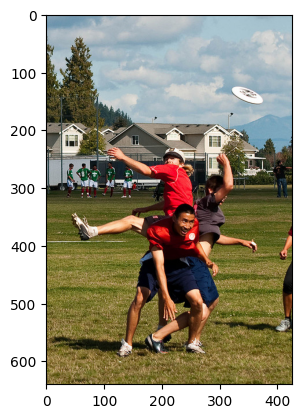

In [17]:
classify_image(model_combined, IMAGES_PATH+'/000000002907.jpg')

No person


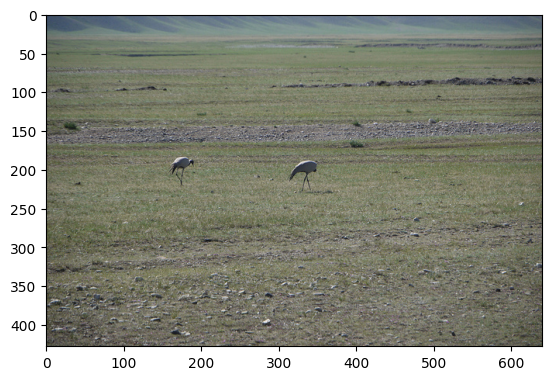

In [19]:
classify_image(model_combined, IMAGES_PATH+'/000000091754.jpg')